# **Examen P1 - grupo del jueves**

Aprendizaje Automático II (2025-2026)

## 

## 0) Datos y utilidades

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance

# Cargar dataset (mismo que en solucion_P1)
data = load_breast_cancer()
X, y = data.data, data.target

# Split 80/20 para el examen (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalado tipo MinMax para euclídea y chi2 (no negatividad)
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

## 1) KNN
### 1.1 KNN ponderado (KNNp)
- k=5, métrica Euclidean, split 80/20.
- Peso por vecino usando $\exp(-q\,r)$, donde r es el rango (1..k). Con q=0 se recupera KNN clásico.

In [2]:
class KNNp:
    def __init__(self, k=5, q=0.0, metric='euclidean', p=2):
        if not isinstance(k, int) or k < 1:
            raise ValueError("k debe ser un entero positivo")
        if q < 0:
            raise ValueError("q debe ser >= 0")
        self.k = k
        self.q = q
        self.metric = metric
        self.p = p
        self._fitted = False

    def get_params(self, deep=True):
        return {"k": self.k, "q": self.q, "metric": self.metric, "p": self.p}

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        if X.shape[0] != y.shape[0]:
            raise ValueError("X e y deben tener el mismo número de ejemplos")
        if self.k > X.shape[0]:
            raise ValueError("k no puede ser mayor que el número de muestras")
        self.X_train = X
        self.classes_, y_enc = np.unique(y, return_inverse=True)
        self.y_train_enc = y_enc
        self._fitted = True
        return self

    def _cdist(self, X):
        if callable(self.metric):
            return distance.cdist(X, self.X_train, metric=self.metric)
        if self.metric == 'minkowski':
            return distance.cdist(X, self.X_train, metric='minkowski', p=self.p)
        return distance.cdist(X, self.X_train, metric=self.metric)

    def predict(self, X):
        if not self._fitted:
            raise RuntimeError("Debes llamar a fit antes de predecir")
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        dists = self._cdist(X)
        # Selección de k vecinos por fila (O(n)) y después ordenar esos k para rango r=1..k
        idx_k = np.argpartition(dists, kth=self.k - 1, axis=1)[:, :self.k]
        d_k = np.take_along_axis(dists, idx_k, axis=1)
        order = np.argsort(d_k, axis=1)
        idx_sorted = np.take_along_axis(idx_k, order, axis=1)
        y_neigh = self.y_train_enc[idx_sorted]

        m = X.shape[0]
        n_classes = len(self.classes_)
        ranks = np.arange(1, self.k + 1, dtype=float)[None, :]
        weights = np.exp(-self.q * ranks)              # (1, k)
        weights = np.repeat(weights, m, axis=0)        # (m, k)

        preds = np.empty(m, dtype=int)
        for i in range(m):
            wsum = np.bincount(y_neigh[i], weights=weights[i], minlength=n_classes)
            preds[i] = int(np.argmax(wsum))
        return self.classes_[preds]

In [3]:
# Demostración rápida con q=0 (clásico) y q=1
k = 5
for q in [0.0, 1.0]:
    model = KNNp(k=k, q=q, metric='euclidean').fit(X_train_s, y_train)
    tr = accuracy_score(y_train, model.predict(X_train_s))
    te = accuracy_score(y_test,  model.predict(X_test_s))
    print(f"q={q:.1f} -> train={tr:.4f}, test={te:.4f}")

q=0.0 -> train=0.9780, test=0.9825
q=1.0 -> train=1.0000, test=0.9386


### 1.2 Optimización del rango (q)
- Barrido de q en [0, 2] con paso 0.1.
- Gráfica accuracy vs q para train y test.
- Repetir la gráfica con validación cruzada (CV).

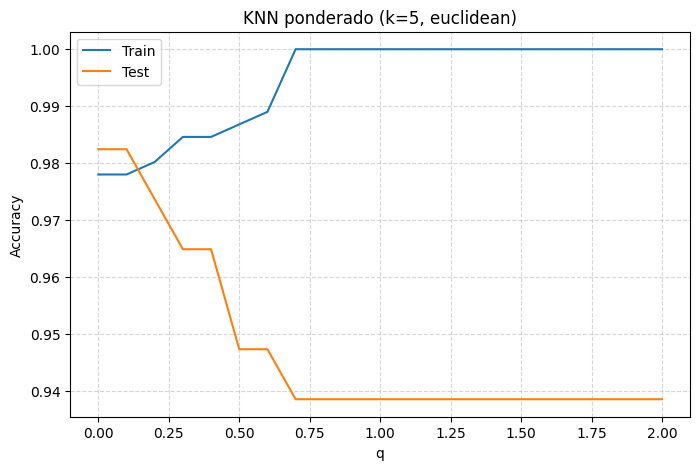

Mejor q (hold-out): 0.0 con accuracy test = 0.9825


In [ ]:
# Hold-out (train/test) vs q
qs = np.round(np.arange(0, 2.0 + 1e-9, 0.1), 2)
train_acc = []
test_acc = []

for q in qs:
    mdl = KNNp(k=5, q=q, metric='euclidean')
    mdl.fit(X_train_s, y_train)
    train_acc.append(accuracy_score(y_train, mdl.predict(X_train_s)))
    test_acc.append(accuracy_score(y_test,  mdl.predict(X_test_s)))

best_q = float(qs[int(np.argmax(test_acc))])

plt.plot(qs, train_acc, label='Train')
plt.plot(qs, test_acc, label='Test')
plt.xlabel('q')
plt.ylabel('Accuracy')
plt.title('KNN ponderado (k=5, euclidean)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print(f"Mejor q (hold-out): {best_q} con accuracy test = {max(test_acc):.4f}")

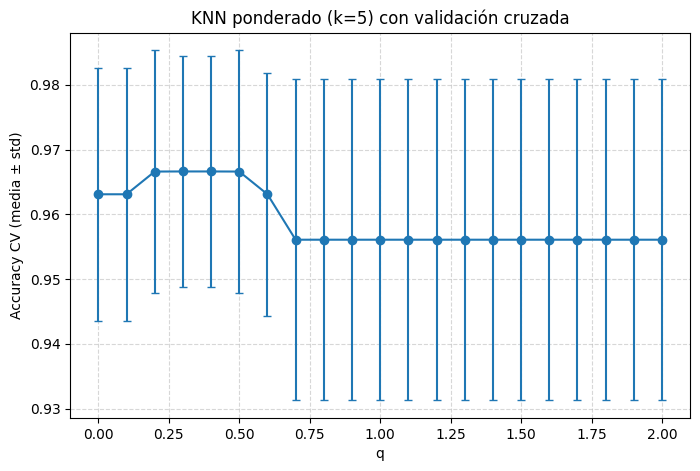

Mejor q (CV): 0.3 con accuracy CV = 0.9666 ± 0.0179


In [ ]:
# Validación cruzada vs q (CV en todo X,y con escalado dentro del Pipeline)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_means = []
cv_stds = []

for q in qs:
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('knnp', KNNp(k=5, q=q, metric='euclidean'))
    ])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

best_q_cv = float(qs[int(np.argmax(cv_means))])

plt.errorbar(qs, cv_means, yerr=cv_stds, fmt='-o', capsize=3) #####################
plt.xlabel('q')
plt.ylabel('Accuracy CV (media ± std)')
plt.title('KNN ponderado (k=5) con validación cruzada')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"Mejor q (CV): {best_q_cv} con accuracy CV = {max(cv_means):.4f} ± {cv_stds[int(np.argmax(cv_means))]:.4f}")

## 2) Selección de atributos (SelectPercentile + chi2)
Barrido del hiperparámetro `percentile` entre 10 y 100 (paso 5), con KNN (k=5) y métrica Euclidean. Gráficas para train y test. El escalado MinMax asegura no negatividad para chi2.

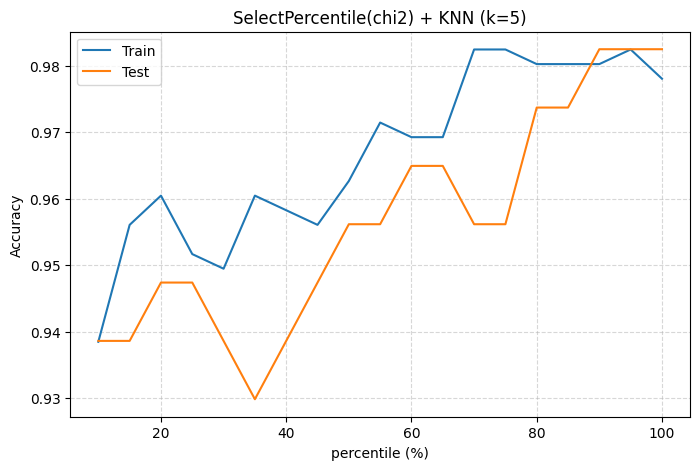

Mejor percentile (hold-out): 90% con accuracy test = 0.9825


In [6]:
percentiles = list(range(10, 101, 5))
train_acc_pct, test_acc_pct = [], []

for pct in percentiles:
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('sel', SelectPercentile(chi2, percentile=pct)),
        ('clf', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
    ])
    pipe.fit(X_train, y_train)
    y_tr = pipe.predict(X_train)
    y_te = pipe.predict(X_test)
    train_acc_pct.append(accuracy_score(y_train, y_tr))
    test_acc_pct.append(accuracy_score(y_test, y_te))

best_pct = percentiles[int(np.argmax(test_acc_pct))]

plt.plot(percentiles, train_acc_pct, label='Train')
plt.plot(percentiles, test_acc_pct, label='Test')
plt.xlabel('percentile (%)')
plt.ylabel('Accuracy')
plt.title('SelectPercentile(chi2) + KNN (k=5)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print(f"Mejor percentile (hold-out): {best_pct}% con accuracy test = {max(test_acc_pct):.4f}")

## Conclusiones
- KNN ponderado con k=5 y métrica Euclidean: se ha buscado q∈[0,2] con paso 0.1 y reportado el mejor en hold-out y en CV.
- SelectPercentile(chi2): se ha barrido percentile∈[10,100] paso 5 y reportado el óptimo en test.
- El dataset es el mismo que en la práctica (Breast Cancer), con MinMaxScaler para coherencia con distancias y chi2.